# The Fast Fourier Transform
#### With One Application In Audio Correction

Nicolás Díaz Durana

### Table of Contents

0\. Introduction <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0\.1 The Fourier Series <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0\.1.1 Example of the Fourier Series in Python <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0\.2 Short Introduction to the Fourier Transform <br>
1\. The Discrete Fourier Transform (DFT) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1\.1 DFT in Python <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1\.2 Limitations of the DFT <br>
2\. The Fast Fourier Transform<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.1 FFT: Practical Approach <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.2 FFT: The Mathematics Behind the Algorithm <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.2.1 Symmetries in the DFT <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.2.2 Divide and Conquer Algorithm <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.3 FFT Efficiency Comparison <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.3.1 A recursive FFT <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.3.2 FFT using Numpy <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2\.3.3 FFT using SciPy <br>
3\. Gauss and the History of the FFT <br>
4\. Real-life Application: FFT for Audio Correction <br>
5\. Conclusion <br>
6\. References <br>

## 0. Introduction

This work focuses in the Fast Fourier Transform (FFT). It explains its mathematical deduction, illustrates its mechanics through some Python codes and develops one real-life application. It also gives some historical background to its origins, emphasizing in Gauss' algorithm as the first known formula of the FFT.


There are six sections to this work. Chapter zero gives a superficial background on the Fourier Series and the Fourier Transform. Chapter one explains the Discrete Fourier Transform (DFT) (the FFT is one version of the DFT), gives an example in Python and mentions its limitations regarding speed. Chapter two develops the mathematical deduction of the FFT and presents three different ways of developing it in Python: through recursion, using Numpy and using SciPy. Chapter three presents the link between the modern version of the FFT and Gauss' algorithm. Chapter four shows one real-life application of the FFT in audio correction. A general conclusion is presented in chapter five. Chapter six contains the references for further reading on the topic. 

### 0.1 The Fourier Series

<img src='fourier_series.jpg' width="500" height="600">

Image: Wolfram MathWorld<br/>
A Fourier series is an expansion of a periodic function f(x) in terms of an infinite sum of sines and cosines. Fourier series recur to the orthogonality relationships of the sine and cosine functions. Harmonic analysis is the name given to the study of Fourier series. It is extremely useful as a way to transform a periodic function into a set of simple terms that can be solved individually and then recombined to obtain an approximate yet accurate solution to the original problem. 

#### 0.1.1 Example of the Fourier Series in Python

$f(x)=\left\{\begin{array}{ll}5 & \text { if } \quad 0<x<\pi / 2 \\ -5 & \text { if }-\pi / 2<x<0 \\ 0 & \text { if } \pi / 2<|x|<\pi\end{array}\right.$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
import math

In [2]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

In [3]:
#Define domain
x = 0
dx = 0.001
L = np.pi
x = L * np.arange(-1+dx,1+dx,dx)
n = len(x)
nquart = int(np.floor(n/4))
print(len(x))

2000


In [4]:
def fourier(x,f,pasos,L,dx):
    A0 = np.sum(f * np.ones_like(x)) * dx
    fFS = A0/2
    A = np.zeros(pasos)
    B = np.zeros(pasos)
    for k in range(pasos):
        A[k] = np.sum(f * np.cos(np.pi*(k+1)*x/L)) * dx #Inner product
        B[k] = np.sum(f * np.sin(np.pi*(k+1)*x/L)) * dx
        fFS = fFS + A[k]*np.cos((k+1)*np.pi*x/L) + B[k]*np.sin(np.pi*(k+1)*x/L)
    return fFS

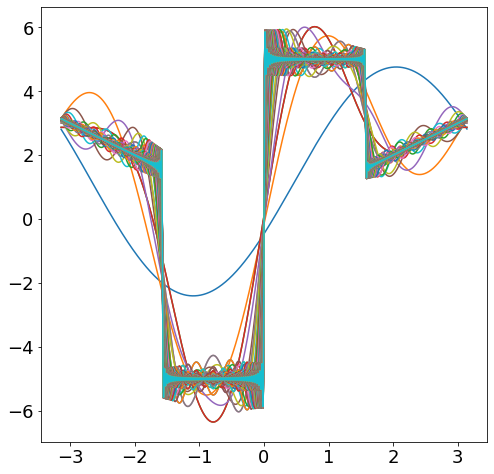

In [5]:
partes=np.zeros_like(x)
cuatro = int(np.floor(len(x)/4))
for i in range(cuatro):
    partes[i]=-x[i]
    partes[i+cuatro]=-5
    partes[i+2*cuatro]=5
    partes[i+3*cuatro]=x[i+3*cuatro]

fig, ax = plt.subplots()
name = 'Accent'
cmap = get_cmap('tab10')
colors = cmap.colors
ax.set_prop_cycle(color=colors)

#Establece la cantidad de senos y cos que se utilizan
corte=200
dx = 0.001
for i in range(corte):
    p=fourier(x,partes,i+1,L,dx)
    ax.plot(x,p,'-')

### 0.2 Short Introduction to the Fourier Transform

The Fourier Transform is a mathematical operation that changes the domain of a signal from time to frequency. This has multiple applications in real-life.

The main idea behind the Fourier transform is that any continuous signal in the time domain can be represented by an infinite series of sinusoids. This means that, if we have a signal and this signal is generated by some function $x(t)$ then we can come up with another function $f(t)$ such that:

$$\large f(t) = \frac{a_0}{2}+\sum_{k=1}^\infty(a_k\text{ cos }2\pi kt + b_k\text{ sin } 2\pi kt)$$

The values that determine the shape of the signal are $a_k$ and $b_k$, which can be obtained by solving the integral

$$\large X(F)=\int_{-\infty}^\infty x(t)e^{-2 \pi iFt}dt$$

However, this applies only in the case of continous functions. This is not the interest of this work: we will focus exclusively in discrete functions. 

## 1. The Discrete Fourier Transform (DFT)

The Discrete Fourier transform is a function that can change a sequence of equally sized signals into the frequencies of all the sine waves that add up to create the time domain of the given signal. Consider the generalization of a discrete funciton, $f(t)\rightarrow f(t_k)$, we get

\begin{equation*}
    \begin{split}
        \large X_k 
        &= \large \sum_{n=0}^{N-1}x_n\cdot e^{-\frac{i2\pi}{N}kn}\\
        &= \large \sum_{n=0}^{N-1}x_n \cdot\Bigg[\text{cos}\bigg(\frac{2\pi}{N}kn\bigg)-i\cdot\text{sin}\bigg(\frac{2\pi}{N}kn\bigg)\Bigg]
    \end{split}
\end{equation*}

where the second expression is obtained from the first using Euler's formula: $e^{ix}=\text{cos }x+i\cdot \text{sin }x$ and

$N$ = number of samples

$n$ = current sample

$k$ = current frequency, where $k∈[0,N−1]$

$x_n$ = the sine value at sample $n$

$X_k$ = The DFT which include information of both amplitude and phase

In general, the discrete Fourier transform of a real sequence of numbers will be a sequence of complex numbers of the same length. In particular, if $f_k$ are real, then $F_{N-n}$ and $F_n$ are related by

$$\large F_{N-n}=\overline{F}_{n}$$

for $n=0, 1, ..., N-1$, where $\overline{z}$ if the complex conjugate. This means that the component $F_0$ is always real for real data.

The $X_k$ is a complex number that contains information about both the amplitude and phase of a complex sinusoidal described by $e^{i2\pi kn/N}$ of function $x_n$. The amplitude and phase of the signal are given by:

$$\large  \text{amp}=\frac{|X_k|}{N}=\frac{\sqrt{Re(X_k)^2+Im(X_k)^2}}{N}$$


$$\large \text{phase}=atan2(Im(X_k),Re(X_k))$$

where $atan2$ is the two-argument form of the $arctan$ function.

If we normalize it by the number of sample points, then the amplitudes returned by DFT will be equal to the amplitudes of the signals we initially put into the DFT . With this, if the input signal is a real-valued sequence as above, the spectrum of the positive and negative frequencies will be symmetric. Therefore, one side only will be enough to reach a valid result and the algorithm will be much more efficient, for we will be dividing by $N/2$ rather than by $N$ in order to get the amplitude corresponding to the time domain signal. This means that a periodic function will contain transformed peaks in two places. 

### 1.1 DFT in Python

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

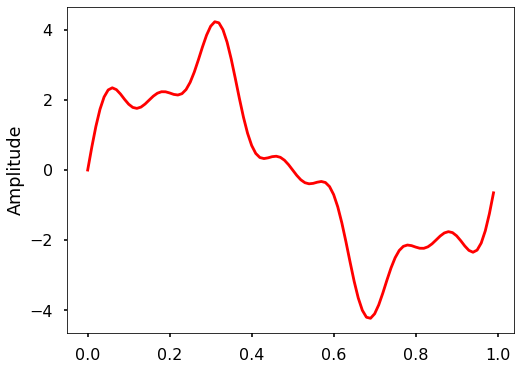

In [7]:
# sampling rate
sr = 100
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

"""""
Generate 3 sine waves with 
frequencies 1 Hz, 4 Hz, and 7 Hz, 
amplitudes 3, 1 and 0.5, 
and phase all zeros. 
"""""

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.show()

Here, we write a function DFT(x) which takes in one argument, x - input 1 dimensional real-valued signal. The function will compute the DFT of the signal and return the DFT values. We will apply this function to the signal we generated above and plot the result.

In [8]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x) #number of samples
    n = np.arange(N) #current sample
    k = n.reshape((N, 1)) #current frequency
    e = np.exp(-2j * np.pi * k * n / N) 
    
    X = np.dot(e, x)
    
    return X

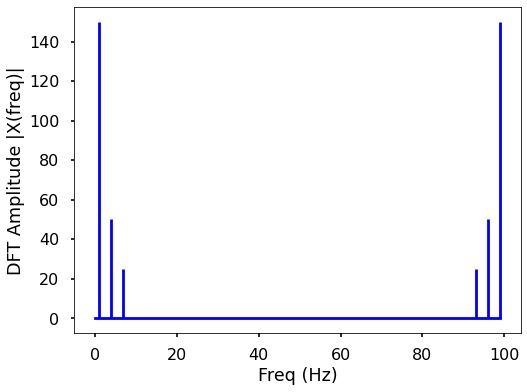

In [9]:
X = DFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr #samples/sampling rate
freq = n/T 

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()

Clearly, the output of the DFT is symmetric at half of the sampling rate. This is called Nyquist frequency or folding frequency, after the electronic engineer Harry Nyquist. Today we refer to the Nyquist-Shannon sampling theorem, which states that a signal sampled at a rate can be fully rebuilt if it contains only frequency components below half that sampling frequency. This means that the highest frequency output from the DFT is half the sampling rate.



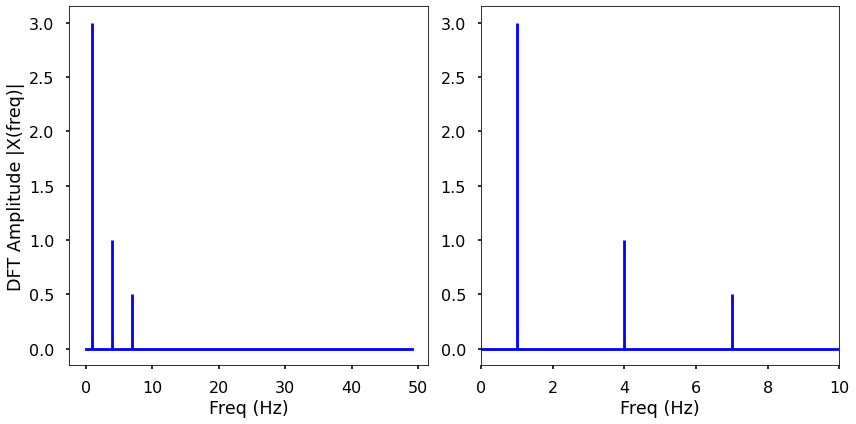

In [10]:
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

By plotting the first half of the DFT results, we can see three peaks at frequencies 1 Hz, 4 Hz, and 7 Hz, with amplitude 3, 1, 0.5. 



The inverse transform of the DFT reads:

$$\large x_n=\frac{1}{N}\sum_{k=0}^{N-1}X_k \cdot e^{i\cdot 2\pi kn/N}$$

We will use a FFT version of this inverse transform in section 2.

### 1.2 Limitations of the DFT

The problem with the DFT implementation in the previous section is that it will not be not efficient enough if our signal has many data points. It may take a long time to compute the DFT if the signal is large.

We will write a function to generate a simple signal with different sampling rate, and see the difference of computing time by varying the sampling rate.

In [11]:
def gen_sig(sr):
    '''
    function to generate
    a simple 1D signal with
    different sampling rate
    '''
    ts = 1.0/sr
    t = np.arange(0,1,ts)

    freq = 1.
    x = 3*np.sin(2*np.pi*freq*t)
    return x

In [12]:
# sampling rate =2000
sr = 2000
%timeit DFT(gen_sig(sr))

424 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# sampling rate 4000
sr = 4000
%timeit DFT(gen_sig(sr))

In [ ]:
# sampling rate 8000
sr = 8000
%timeit DFT(gen_sig(sr))

As the number of data points increase, a higher computation time is needed. The Fast Fourier Transform (FFT), popularized by Cooley and Tukey 1965, solves this problem.

# 2. The Fast Fourier Transform (FFT)

## 2.1 FFT: Practical Approach

First, we will create a sine wave. Sine waves are sometimes called pure tones because they represent a single frequency. This will be useful to see the FFT in action.

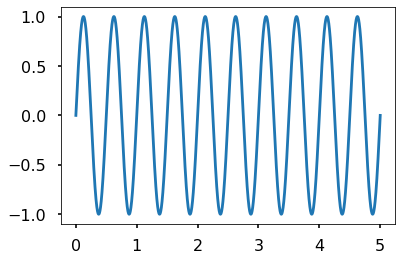

In [13]:
import numpy as np
from matplotlib import pyplot as plt

SAMPLE_RATE = 44100  # Hertz / Number of data points the signal uses to represent the sine wave per second
DURATION = 5  # Seconds / Length of the generated sample

"""""
This function takes a frequency and then 
returns the x and y values to plot the wave
"""""

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False) #False means the function is periodic
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies) # 2pi because np.sin takes radians
    return x, y

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

This sine wave is too low a frequency to be audible, so now we will generate some higher-frequency sine waves and mix them.

In [14]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION) #Normal pitch tone 400 Hertz
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION) #High pitch distorted tone 4000 Hertz
noise_tone = noise_tone * 0.3 #Times 0.3 to reduce its volume

mixed_tone = nice_tone + noise_tone #Add up both tones

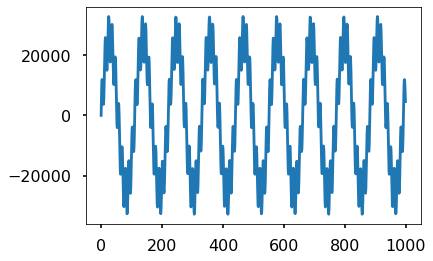

In [15]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767) #Scaling the signal to fit into the target format

plt.plot(normalized_tone[:1000])
plt.show()

The signal looks like a distorted sine wave. The original sine wave is 400 Hz and the distortion is the 4000 Hz tone.

In [16]:
from scipy.io.wavfile import write

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)

In [17]:
from IPython.display import Audio
import numpy
import scipy.io.wavfile
%matplotlib inline


In [23]:
samplingrate, song = scipy.io.wavfile.read('C:/Users/Station/Documents/EDP/mysinewave1.wav')

In [24]:
samplelength = 5*samplingrate
songsample = song.sum(axis=1)[:samplelength]

In [25]:
Audio(songsample, rate=samplingrate) #Sine wave

Now we will use the FFT algorithm. The FFT can calculate a frequency spectrum for a signal in the time domain, which is useful in this case.

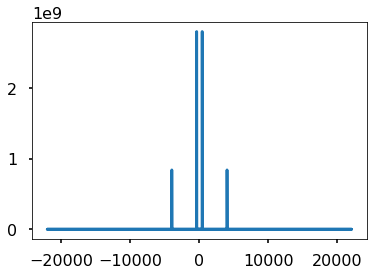

In [26]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

The two peaks in the positive frequencies are mirrored in the negative frequencies. The positive-frequency peaks are at 400 Hz and 4000 Hz, which corresponds to the frequencies.

**Now we calculate the Fourier transform:**

In [27]:
yf = fft(normalized_tone) #calculates the transform itself
xf = fftfreq(N, 1 / SAMPLE_RATE) #calculates the frequencies in the center of each bin in the output
# A bin is a range of values that have been grouped

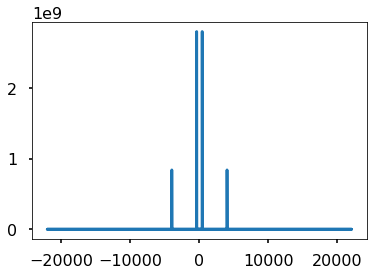

In [28]:
plt.plot(xf, np.abs(yf)) #We use np.abs because the values are complex. This gives us the complex conjugate.
plt.show()

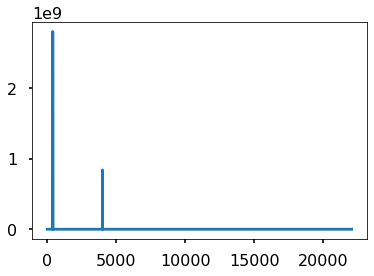

In [29]:
from scipy.fft import rfft, rfftfreq

# Calculates only the positive part of the frequency spectrum. It's quicker.
yf = rfft(normalized_tone) #Compute the one-dimensional DFT for real input
xf = rfftfreq(N, 1 / SAMPLE_RATE) #Same but for frequency

plt.plot(xf, np.abs(yf))
plt.show()

In [30]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is 4000 Hz
target_idx = int(points_per_freq * 4000)

Now we set $yf$ to $0$ around the target frequency to get rid of it:

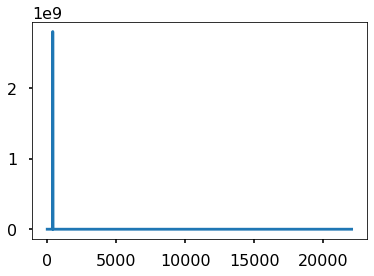

In [31]:
yf[target_idx - 1 : target_idx + 2] = 0 #Getting rid of the distorted sound

plt.plot(xf, np.abs(yf))
plt.show()

**Now we apply the inverse Fourier transform to get back to the time domain.**

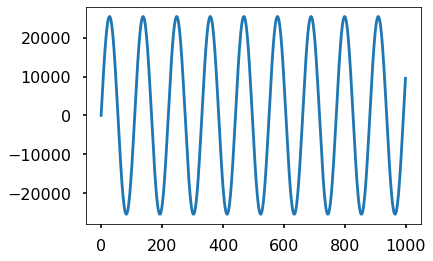

In [32]:
from scipy.fft import irfft #Inverse FFT

new_sig = irfft(yf)

plt.plot(new_sig[:1000])
plt.show()

In [33]:
norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))

write("clean.wav", SAMPLE_RATE, norm_new_sig)

In [34]:
samplingrate, song = scipy.io.wavfile.read('C:/Users/Station/Documents/EDP/clean1.wav')

In [35]:
samplelength = 5*samplingrate
songsample = song.sum(axis=1)[:samplelength]

In [36]:
Audio(songsample, rate=samplingrate) #Clean sine wave

## 2.2 FFT: The Mathematics Behind the Algorithm

The Fast Fourier Transform (FFT) is an efficient algorithm that reduces the complexity of the DFT from O($N^2$) to O($N\text{log}N$), where $N$ is the size of the data. This reduction is significant in computation time, especially for data with large $N$. 

### 2.2.1 Symetries in the DFT

Exploiting the symmetries in the DFT is the critical aspect of the FFT algorithm. This is the DFT equation:

$$\Large X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-\frac{i2\pi}{N}kn}$$

From here, we can calculate:

$$\Large X_{k+N}=\sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi(k+N)n/N}=\sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi n}\cdot e^{-i2\pi kn/N}$$

Since $e^{-i2\pi n}=1$, we can rewrite

$$\Large X_{k+N}=\sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi kn/N}=X_k$$

which means that we have symmetries within the DFT. These can be used to optimize the algorithm.

### 2.2.2 Divide and conquer algorithm

Cooley and Tukey showed that it's possible to divide the DFT computation into two smaller parts. Again, from the definition of the DFT we have:

\begin{equation*}
    \begin{split}
        \Large X_k 
        &= \Large\sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi kn / N}\\
        &= \Large\sum_{m=0}^{N/2-1}x_{2m}\cdot e^{-i2\pi k(2m) / N} 
        + \sum_{m=0}^{N/2-1}x_{2m+1}\cdot e^{-i2\pi k(2m+1) / N}\\
        &= \Large \sum_{m=0}^{N/2-1}x_{2m}\cdot e^{-i2\pi km / (N/2)} 
        + e^{-i2\pi k / N}\sum_{m=0}^{N/2-1}x_{2m+1}\cdot e^{-i2\pi km / (N/2)}\\
    \end{split}
\end{equation*}

With this, the Discrete Fourier transform has been split into odd-numbered values and even-numbered values. Each term consists of $(N/2)\cdot N$ computations, for a total of $N^2$.

We know that the range of k is $0≤k<N$ and the range of $n$ is $0≤n<M\equiv N/2$. Observing the symmetry that is created, we realize only half the computations are necessary for each sub-problem. With this, the $O[N^2]$ computation has become $O[M^2]$, with $M$ half the size of $N$.

This divide-and-conquer algorithm can be reimplemented as need, halving the computational cost each time, until our arrays are too small to continue. In the limit of this process, this recursive approach reaches a computational value of $O[NlogN]$.

## 2.3 FFT Efficiency Comparison

### 2.3.1 A recursive FFT

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline

In [38]:
def FFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey FFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)
        
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X

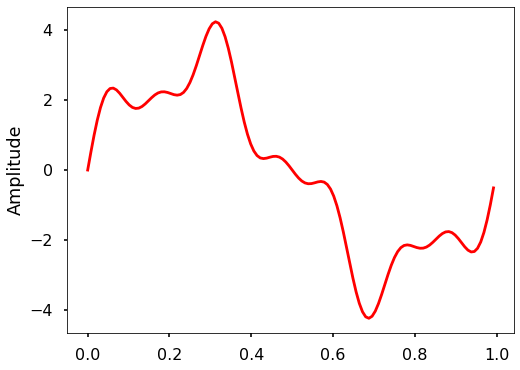

In [39]:
# sampling rate
sr = 128
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

freq = 4
x += np.sin(2*np.pi*freq*t)

freq = 7   
x += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')

plt.show()

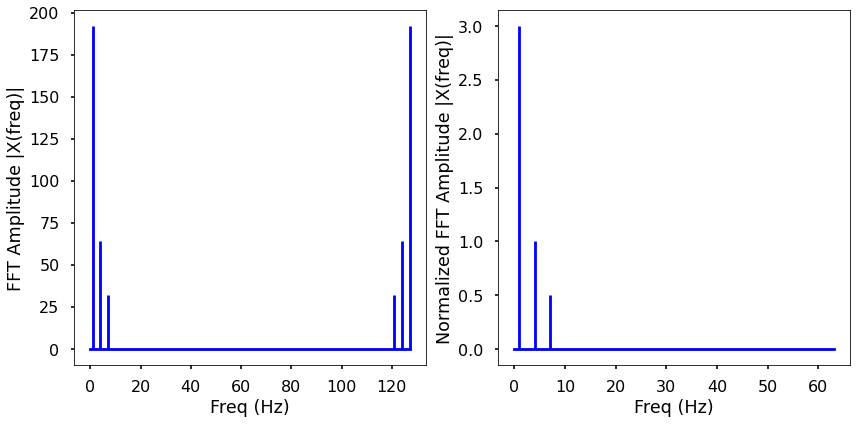

In [40]:
X=FFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalized FFT Amplitude |X(freq)|')
plt.tight_layout()
plt.show()

In [41]:
%timeit FFT(x)

2.27 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 2.3.2 FFT using Numpy

C:\Users\Station\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


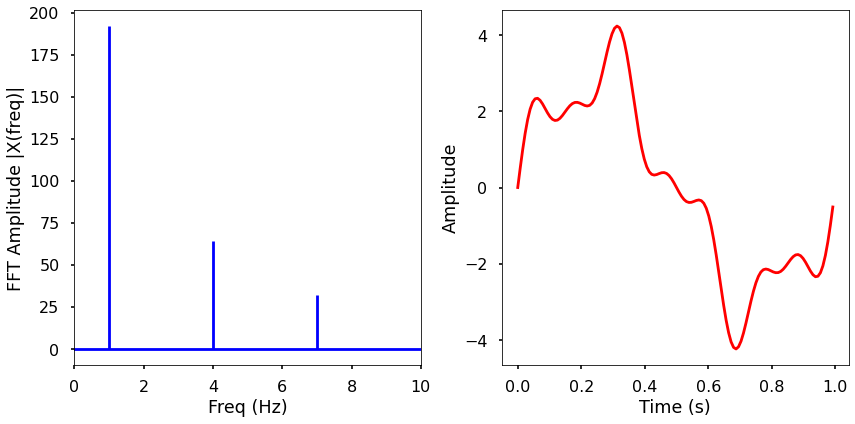

In [42]:
from numpy.fft import fft, ifft #FFT in Numpy

X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [43]:
%timeit fft(x)

7.18 µs ± 338 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### 2.3.3 FFT using Scipy

C:\Users\Station\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


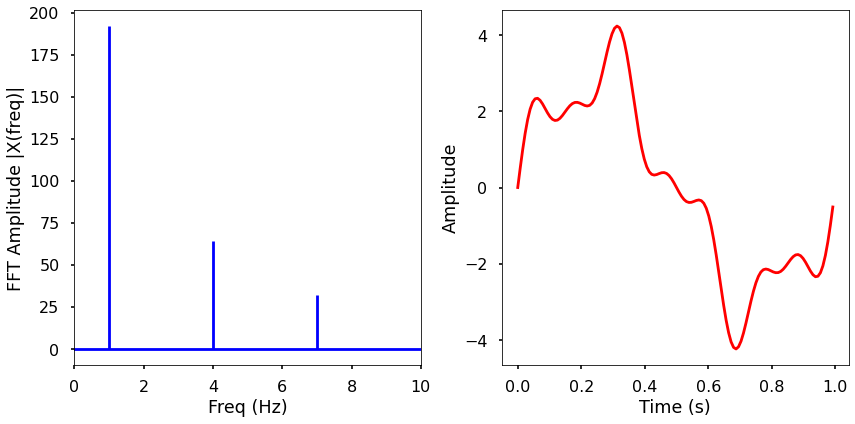

In [44]:
from scipy.fftpack import fft, ifft #FFT in Scipy

X = fft(x)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [45]:
%timeit fft(x)

12 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## 3. Gauss and the History of the Fast Fourier Transform

The paper that popularized the Fourier Fast Transform was published by Cooley and Tukey in 1965. The only influence mentioned by these authors in their work was that of I.J. Good, published in 1958, about an algorithm called the Prime Factor Algorithm (PFA). However, today it is clear that there are big differences between the FFT and the PFA, and deep historical research has been done into the origins of the FFA. 

A work published by Heideman _et al._ in 1984 brings forth the fact that the first ever recorded algorithm similar to the FFT for the computation of the coefficients of a finite Fourier series was made by Carl Friedrich Gauss in 1805. His notes were not published until after his death, and the year on which he wrote it has undergone debate. If the year is correct, it is suprisignly close to Fourier's 1807 work on harmonic analysis, which would set the stage for the Fourier series as we know them.

The reason why Gauss' work might have gone unnoticed for more than 100 years is the fact that Gauss wrote it in his personal mathematical diary, in a nineteenth-century version of Latin, known today as neo.Latin. Also, the notation used by Gauss to describe his method is radically different to modern notation. These two elements make it very difficult to the modern reader to translate his work accurately. Examples of his notation  are the use of symbols $a,b,c,...;a',b',c',...;a'',b'',c'',...;$ etc. are the indices of the time series; also, the use of capital letters to refer to the value of a function at a certain point (for example, $f(a)=A$). Additionally, Gauss used trigonometric functions instead of complex exponentials, which in a way hid the fact that his method  is closely related to modern FFT techniques.

It is known that Gauss read the works of Alexis-Claude Clairaut (1754) about what is considered to be the earliest formula of the Discrete Fourier Transform (DFT), but restricted to a cosine-only finite Fourier series. He also read the work published by Lagrange in 1762 about a DFT-like formula for sine-only series.

Gauss was working on the problem of determining the orbit of certain asteroids when he began to extend his work on trigonometric interpolation to periodic functions, which do not fall into the category of even or odd. These functions go as follows:

$$\Large f(x)=\sum_{k=0}^m a_k \text{ cos }2\pi kx + \sum_{k=1}^m b_k \text{ sin }2\pi kx$$

where $m=\frac{N-1}{2}, N$ odd, or $m=\frac{N}{2}, N$ even. Gauss showed that if the values $f(x_n),x_n=\frac{n}{N},(n=0,1,2,...,N-1)$  are known, then the coefficients $a_k$ and $b_k$ can be found. These equations are, in fact, the first known explicit formula for the general DFT.

Gauss' algorithm is built as follows: <br>
1) Consider $N_1$ equally spaced samples over one period of a signal. This set is a subset of $N$ total samples. <br>
2) Using $m$ harmonics, with $m=\frac{N-1}{2}, N$ odd, or $m=\frac{N}{2}$, compute the finite Fourier series which passes through these samples. <br>
3) Consider another subset of $N_1$ equally spaced samples, which are displaced or offset from the original set of samples by $1/N_2$, $N_2$ positive integer. <br>
4) Compute a finite Fourier series passing through this signal, with $m$ harmonics. Here Gauss realized that these coefficients are visibly different from those computed in the original $N_1$ samples. <br>
5) To solve this problem, measure a total of $N_2$ sets of $N_1$ equally spaced samples. This way, the finite Fourier series of the whole set $N$ is computed by, first, computing the coeficients for the $N_2$ sets of length $N_1$, and then computing the coefficients for the $N_1$ sets of length $N_2$

To understand better Gauss' algorithm, consider this version of the modern DFT: 

$$\Large C(k)=\sum_{n=0}^{N-1} X(n)W_{N}^{nk}$$

Here, f(x) has period of one, the $N$ equally spaced samples are represented by $N=f(n/N)$, and the indices of the Fourier coefficients are $W_N=\text{exp}(-i2\pi/N)$ and $k=0,1,2,...,N_2-1$.

The indices ot the Fourier coefficients are denoted by $N-1$. We can rewrite them in terms of $N_2$ sets of $N_1$ subsamples (as Gauss considered it) as follows:

\begin{split}
    \large n &= \Large N_2n_1+n_2 \\
    \large k &= \Large k_1+N_1k_2
\end{split}

for $n_1,k_1=0,1,2,...,N-1$  and $n_2,k_2=0,1,2,...,N-1$. <br>


Considering that each subsequence is a function of $n_1$ and that $n_2$ defines which subsequence we are refering to, the modern DFT can be rewritten as:

$$\Large C(k_1+N_1k_2)=\sum_{n_2=0}^{N_2-1}\Bigg[\sum_{n_1=0}^{N_1-1}X(N_2n_1+n_2)W_{N_1}^{n_1k_1}W_{N}^{n_2k_1}\Bigg]W_{N_2}^{n_2k_2}$$

The inner sum computes de DFT's of $N_2$ length (corrected by $W_N$) and the outer sum calculates the DFT's of length $N_1$. 

What is incredible about this formula is that it is the exact same Fast Fourier Transform algorithm as proposed by Cooley and Tukey in 1965, however difficult it may be to realize it because of notation and translation reasons: 

$$ \large F(m,n)=\frac{1}{MN}\sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x,y)exp\Big( -2\pi i\big(\frac{x}{M}m+\frac{y}{N}n\big) \Big) $$

Here, $f(x,y)$ is a two dimensional surface $MxN$, with $x=0,1,2,3,...,M-1$ and $y=0,1,2,3,...,N-1$. 

For further reading and details, refer to Heideman (1985) in the References.

## 4. Real-life Application: FFT for Audio Correction

In [46]:
from IPython.display import Audio
import numpy
import scipy.io.wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
fs = 44100  # sampling frequency, Hz This is the rate at which CDs are sampled.
T = 0.5  # note length, seconds
twopi = 2*numpy.pi
t = numpy.linspace(0, T, int(T*fs), endpoint=False) # time variable

In [48]:
samplingrate, song = scipy.io.wavfile.read('C:/Users/Station/Documents/EDP/velandia1.wav')

In [49]:
dt = 1/samplingrate

In [50]:
samplelength = 23*samplingrate
songsample = song.sum(axis=1)[:samplelength]

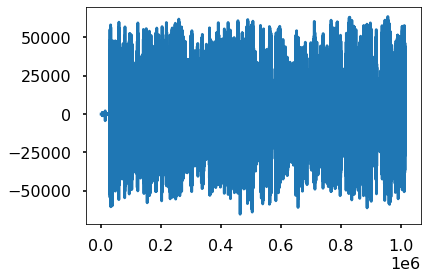

In [51]:
plt.plot(songsample)

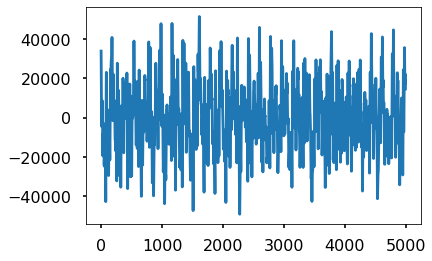

In [52]:
plt.plot(songsample[100000:105000])

In [53]:
Audio(songsample, rate=samplingrate)

In [54]:
def filtersignal(signal):
    return numpy.convolve(signal, first_order_impulse, 'same')/len(signal)*len(first_order_impulse)

In [55]:
#Filter
omega = 440*twopi  # (440 cycles/second)*(2 pi radians / cycle)
tau = 1/omega
first_order_impulse = numpy.exp(-t/tau)

In [56]:
filtered = filtersignal(songsample)
Audio(filtered, rate=samplingrate)

In [57]:
filtered = filtersignal(filtered)
Audio(filtered, rate=samplingrate)

## 5. Conclusion

This work has shown the conceptual and practical richness of the topic of the Discrete and the Fast Fourier Transforms. Also, it has delved into the historical origins of such a famous and important algorithm. The real-life application example falls short in terms of making visible what this amazing algorithm is capable of. However, it does give an idea of what can be achieved in the field of music and audio-processing. For now, this work has managed to scrape the surface of such deep topic; but clearly, many years of study would be needed to actually master it. 

## 6. References

Cooley, James W., and John W. Tukey, 1965, “An algorithm for the machine calculation of complex Fourier series,” Math. Comput. 19: 297-301



Heideman, M. T., Johnson, D. H., & Burrus, C. S. (1985). Gauss and the history of the fast Fourier transform. Archive for history of exact sciences, 34(3), 265-277.

Kong, Q. et al. Python Numerical Methods: A Guide for Engineers and Scientists (2020)https://pythonnumericalmethods.berkeley.edu/notebooks/Index.html

Fourier Series. https://mathworld.wolfram.com/FourierSeries.html

Fourier Transforms. https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html

Fourier Transforms With scipy.fft: Python Signal Processing. https://realpython.com/python-scipy-fft/#practical-example-remove-unwanted-noise-from-audio

Dynamics and Control With Jupyter Notebooks. https://dynamics-and-control.readthedocs.io/en/latest/1_Dynamics/8_Frequency_domain/Sound%20and%20frequency.html